In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scan-classification-challange/sample_submission.csv
/kaggle/input/scan-classification-challange/df_train.csv
/kaggle/input/scan-classification-challange/df_test.csv


In [2]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 415.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 12.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import re
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
from nltk.stem import WordNetLemmatizer
import pymorphy2
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
#import transformers
#import torch
#import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
#from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
#from transformers import BertTokenizer, BertModel, BertConfig

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train = pd.read_csv('../input/scan-classification-challange/df_train.csv')
train.sample(3)

,text,class
50392,"К тому же сообщается, что Великобритания замор...",Проблемы с активами
52069,Как не нарушить законодательство о противодейс...,Экстремизм
37298,Экс-замминистра просвещения Ракова арестована ...,Заключение под стражу


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    60000 non-null  object
 1   class   60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [6]:
# Посмотрим, что из себя представляет значение с текстом

train['text'][12]

'Как уточняет РИА Новости, помимо административной, блогеру грозит и уголовная ответственность – полиция отправила материалы в Следственный комитет для проверки, подпадает ли поступок под статью о хулиганстве.'

In [7]:
# Удалим дубликаты

train.drop_duplicates(subset={'text'}, inplace=True) 
train.shape

(59402, 2)

In [8]:
# Посмотрим количество текста по каждому классу

train['class'].value_counts()

O                                                   40159
Теракт                                               1837
Взятки                                               1775
Экстремизм                                           1744
Уголовное обвинение                                  1543
Пожары                                               1500
Привлечение к уголовной ответственности              1390
Землетрясение                                         827
Утечка нефти                                          799
Противодействие коррупции                             695
Заключение под стражу                                 667
Поддержка террористов                                 653
Коррупция                                             593
Нарушение закона                                      576
Уголовное задержание                                  500
Наводнение                                            483
Кораблекрушение                                       372
Авиакатастрофа

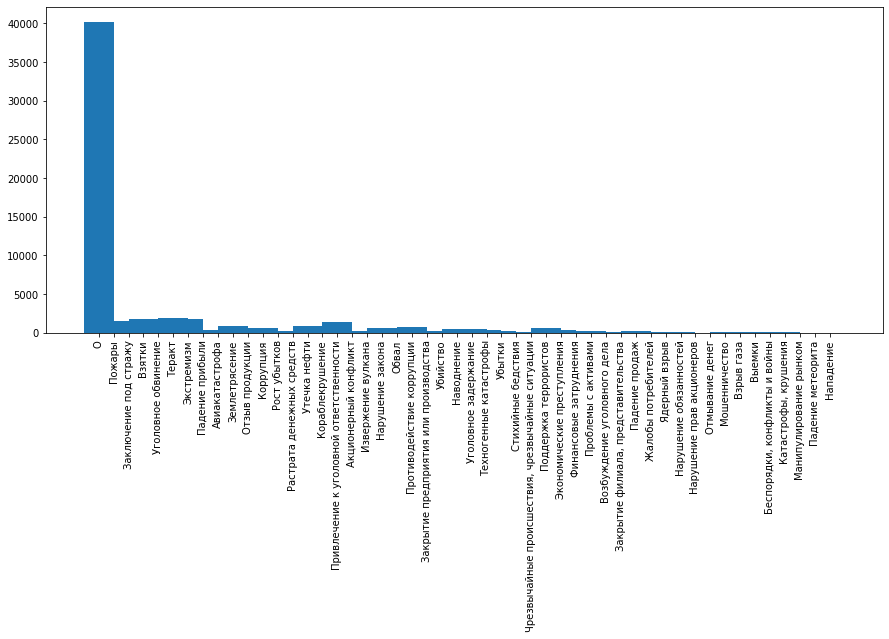

In [9]:
# Видно, что данные сильно не сбалансированны

from collections import Counter
counter = Counter(train['class'])
plt.figure(figsize=(15, 6))
plt.bar(counter.keys(), counter.values(), width=2)
plt.xticks(rotation=90)
plt.show()

In [10]:
# # Названия категорий переводим в числовой формат и записываем в отдельный столбец

train['encoded_cat'] = train['class'].astype('category').cat.codes
train.sample(5)

,text,class,encoded_cat
53368,Причем фермеры платили за пользование системой...,O,0
34792,"Центр ""Э"" и пытки током в деле о подготовке те...",Теракт,38
13523,Аварийная продувка главных балластных цистерн ...,Наводнение,19
55175,"""Подавляющее большинство людей, которые дают п...",O,0
27957,О главных кадровых переменах 2021 года в Алтай...,O,0


In [11]:
train[['class', 'encoded_cat']].value_counts()

class                                             encoded_cat
O                                                 0              40159
Теракт                                            38              1837
Взятки                                            5               1775
Экстремизм                                        48              1744
Уголовное обвинение                               43              1543
Пожары                                            31              1500
Привлечение к уголовной ответственности           32              1390
Землетрясение                                     12               827
Утечка нефти                                      44               799
Противодействие коррупции                         34               695
Заключение под стражу                             9                667
Поддержка террористов                             30               653
Коррупция                                         16               593
Нарушение закон

In [12]:
test = pd.read_csv('../input/scan-classification-challange/df_test.csv', index_col=0)
test.sample(3)

,text,class
342,"На этом основании Суд указал, что судебное обж...",O
22772,Это уголовное дело может помешать американском...,O
39248,"Рассказывая своим партнерам по игре в бридж, о...",O


In [13]:
#Средняя длина, стандартное отклонение, макс.длина столбца text
lens = train.text.str.len()
lens.mean(), lens.std(), lens.max()

(143.69058280865963, 72.06339635294306, 400)

In [14]:
pd.unique(train['class'])

array(['O', 'Пожары', 'Заключение под стражу', 'Взятки',
       'Уголовное обвинение', 'Теракт', 'Экстремизм', 'Падение прибыли',
       'Авиакатастрофа', 'Землетрясение', 'Отзыв продукции', 'Коррупция',
       'Рост убытков', 'Растрата денежных средств', 'Утечка нефти',
       'Кораблекрушение', 'Привлечение к уголовной ответственности',
       'Акционерный конфликт', 'Извержение вулкана', 'Нарушение закона',
       'Обвал', 'Противодействие коррупции',
       'Закрытие предприятия или производства', 'Убийство', 'Наводнение',
       'Уголовное задержание', 'Техногенные катастрофы', 'Убытки',
       'Стихийные бедствия',
       'Чрезвычайные происшествия, чрезвычайные ситуации',
       'Поддержка террористов', 'Экономические преступления',
       'Финансовые затруднения', 'Проблемы с активами',
       'Возбуждение уголовного дела',
       'Закрытие филиала, представительства', 'Падение продаж',
       'Жалобы потребителей', 'Ядерный взрыв', 'Нарушение обязанностей',
       'Нарушение п

In [15]:
# Смотрим кол-во по каждому классу
train['class'].value_counts()

O                                                   40159
Теракт                                               1837
Взятки                                               1775
Экстремизм                                           1744
Уголовное обвинение                                  1543
Пожары                                               1500
Привлечение к уголовной ответственности              1390
Землетрясение                                         827
Утечка нефти                                          799
Противодействие коррупции                             695
Заключение под стражу                                 667
Поддержка террористов                                 653
Коррупция                                             593
Нарушение закона                                      576
Уголовное задержание                                  500
Наводнение                                            483
Кораблекрушение                                       372
Авиакатастрофа

In [16]:
# Посмотрим на состав имеющихся стоп-слов
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
print(stopwords.words("russian"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после'

In [17]:
# Теперь выведем все слова длиной менее 3-х символов и дополним список стоп-слов
# пробовал искать среди стопслов равных 4-м, но там получаем слова 'газа', 'прав', 'дела', 'Рост'
# как мне кажется данные слова, могут быть полезны для score
stopworlds_new = set()
mas_stop = set()
for words in train['text']:
    for i in words.split():
        if len(i) <= 3:
            mas_stop.add(i)
print(mas_stop)

{'-за', 'Шор', 'МИТ', '7,9', 'НПЗ', 'B&C', 'ВТГ', 'г."', 'Q7,', 'ДУМ', '10,', '990', '50%', '5),', '"16', 'оба', '"И', '[…]', 'СГБ', 'Дж.', '523', '2,1', 'ОХК', 'лед', '24.', '746', 'ЖК', '508', 'ЛРН', '084', 'Аюб', 'нон', 'Фог', 'Г-н', '55', '2.1', 'ОС,', '28,', '"А', 'РУ', 'ФАН', 'НДС', '271', '"27', 'дну', 'НБУ', 'вес', '"ОО', 'uz', 'л.', '165', '45"', '16,', 'ГНЦ', 'ВПО', '12', 'ГЭС', 'Мая', '642', '94', 'HD,', '029', 'ФОК', '4%,', 'СЭБ', 'жив', 'а,', 'К10', 'сих', 'ПО', '41-', 'CVV', 'Ее,', 'ГРУ', '(52', 'ту,', '~76', 'св.', 'LEV', 'РБГ', 'с.', '31%', 'УПЦ', '7-й', 'НАК', 'СНК', 'Fan', '349', '6.1', 'то,', 'Ray', '539', 'АО,', '"На', '8%,', '380', 'да.', 'вас', 'XV', '§1', '22%', '1%.', 'г.)', 'Им', '695', '3.7', 'СУТ', 'Так', '420', '23.', 'Лет', 'ФСК', '"ВО', 'КТД', '7,6', '17.', '"я', '85', 'PПK', 'ФИО', 'Ша', 'Уян', '"2.', '2-4', 'НС', '335', 'но', '№6', 'кг,', '296', '26%', 'Чжу', '378', 'Тал', '15-', 'Год', '140', 'Яну', 'аул', '84', '260', 'БГУ', 'CК', 'ни', 'м,', '38', '\u

In [18]:
# Создаем новый список стоп-слов

stopworlds_new = set(stopwords_ru).union(mas_stop)

In [19]:
# Создадим функцию по очистке данных. Будем переводить слова в нижний регистр, 
# удалять стоп слова, удалять числа и раздичные знаки которые не несут смысловой нагрузки. 
# Все слова преобразуем к их первоначалоной форме (Лемматизация)

morph = pymorphy2.MorphAnalyzer()
patterns = "[A-Z|a-z|0-9!#$%&'()*+,./:“″;”<=>?@[\]^_`{|}~—\"\-•–«»]+"
#stops = set(stopwords.words("russian"))
def clean(text):
    text = text.lower()
    text = re.sub(patterns, ' ', text)
    tokens = []
    for token in text.split():
        if token and token not in stopworlds_new:
            token = token.strip()
            token = morph.normal_forms(token)[0]  # Лемматизация
            #token = stemmer.stem(token) # Стеммизация
            tokens.append(token)
    return ' '.join(tokens)

In [20]:
# Применим функцию очистки к train
train['clean'] = train['text'].apply(lambda x: clean(x))
train[['clean', 'text']]

,clean,text
0,продолжать кудрин лично уверенный нацпроект на...,"При этом, продолжает Кудрин, лично он уверен: ..."
1,сотрудник го отдел хранить информация работник...,Сотрудники 1-го отдела хранили информацию о ра...
2,сирийский служба безопасность пока это справля...,Сирийские службы безопасности пока с этим спра...
3,мвд сообщить днк мужчина совпасть образец найт...,"В МВД сообщили, что ДНК мужчины совпала с обра..."
4,сообщить среда пресс секретарь белый дом джена...,Об этом сообщила в среду пресс-секретарь Белог...
...,...,...
59995,представлять тяжело находиться беларусь постоя...,"Я не представляю, как тяжело вам сейчас находи..."
59996,рамка возбудить уголовный дело дать правовой о...,"""В рамках уже возбужденного уголовного дела бу..."
59997,заявить руководитель национальный центральный ...,Об этом заявил руководитель национального цент...
59998,ранее лайф рассказывать тёмный дело мушвиг абд...,Ранее Лайф рассказывал о темных делах Мушвига ...


In [21]:
# Выведем список слов которые часто встречаются, при этом исключим стоп слова

words = list( train['clean'].values)

split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        if w not in stopwords_ru:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

In [22]:
# Получим 10 часто встречающихся слов

from nltk import FreqDist
word_freq = FreqDist(allwords).most_common(10)
word_freq

[('год', 8289),
 ('который', 6320),
 ('сообщить', 5086),
 ('дело', 4812),
 ('заявить', 4386),
 ('россия', 3582),
 ('сказать', 3244),
 ('свой', 3222),
 ('рф', 2934),
 ('сообщать', 2916)]

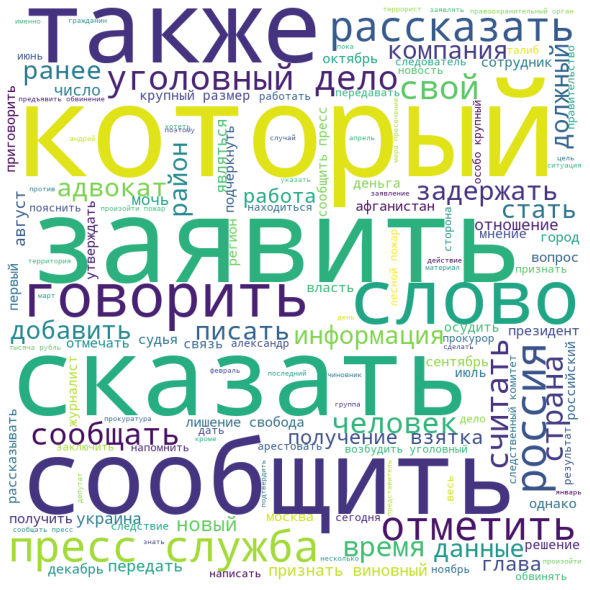

In [23]:
# Выведем облако слов

comment_words = ''
comment_words += " ".join(allwords)+" " 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
               # stopwords = stopwords,
                stopwords = stopworlds_new,
                min_font_size = 10).generate(comment_words)                     
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)